/Users/user/FTS/new_ssd_trim_cnn/ssd.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
/Users/user/FTS/new_ssd_trim_cnn/ssd.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
/Users/user/FTS/new_ssd_trim_cnn/ssd.py:48: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
/Users/user/FTS/new_ssd_trim_cnn/ssd.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  name='conv2_1')(net['pool1'])
/Users/user/FTS/new_ssd_trim_cnn/ssd.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


1/1 [==============================] - 2s


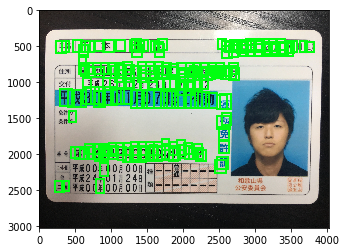

保存完了


In [3]:
# SSDで座標予測

import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
import random

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility




# いじらない！
NUM_CLASSES = 21  #もともと4
input_shape = (300, 300, 3)

model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('checkpoints/weights.29-0.72.hdf5', by_name=True)

bbox_util = BBoxUtility(NUM_CLASSES)


inputs = []
images = []
img_path = '/Users/user/Desktop/menkyo_big.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))
inputs.shape



preds = model.predict(inputs, batch_size=1, verbose=1)



results = bbox_util.detection_out(preds)



zahyou = []
image_point = []
for num, img in enumerate(images):
    # Parse the outputs.
    #  これは予測したもの全てのそれぞれの値が出てしまう！！ラベルである確率が低いものまで全て入ってしまってる
    det_label=results[num][:, 0]
    #  det_confは確率 softmax使ってるから。そのラベルである確率
    det_conf = results[num][:, 1]
    det_xmin = results[num][:, 2]
    det_ymin = results[num][:, 3]
    det_xmax = results[num][:, 4]
    det_ymax = results[num][:, 5]


    # Get detections with confidence higher than 0.6.
    #  確率が６０％以上のものだけのインデックス番号を取り出す
    # →６０％以上の[label, confidence, xmin, ymin, xmax, ymax]＝top_indicesを取り出す
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]


    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]
        
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]
            
        
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.23]

    #if len(top_indices) <= 50:
    #    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.18]
        


    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()


    num = []
    for i in range(top_conf.shape[0]):

        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        # xmax ymaxが右下の座標
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        
        
        #zahyou.append({'{}枚目'.format(num+1): [(xmin,ymin),(xmax , ymin ) ,(xmin, ymax) ,(xmax ,ymax)] })
        score = top_conf[i]
        label_name = int(top_label_indices[i])
        #label_name = voc_classes[label - 1]
        #  表示する文字→確率とラベルの名前catとか

        display_txt=None
        
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        zahyou =  [ xmin, ymin,xmax,ymax ]
        color = colors[label_name]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        
        num.append(zahyou)
    image_point.append(num)
    
    np.save('trim/trimming_images.npy',images)
    np.save('trim/image_point.npy',image_point)
    
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()  


print('保存完了')


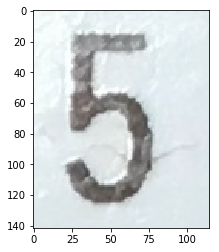

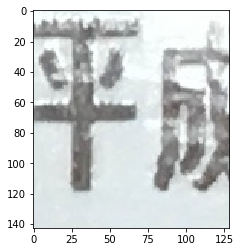

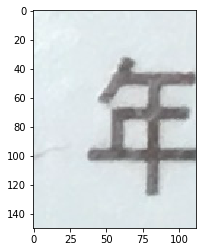

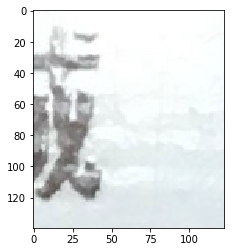

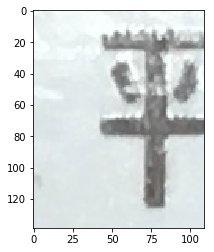

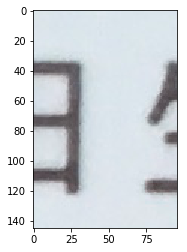

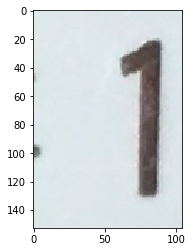

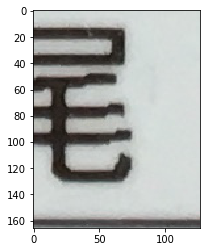

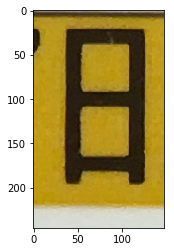

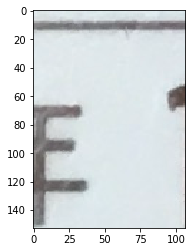

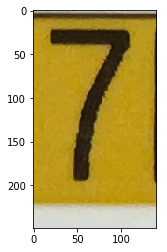

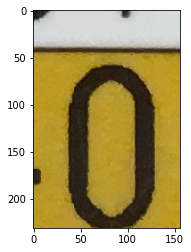

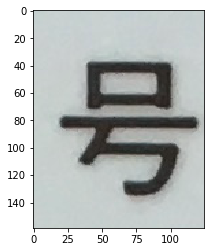

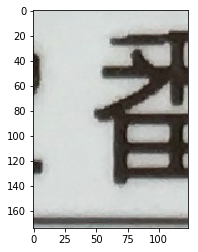

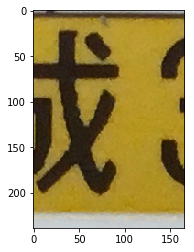

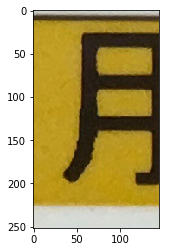

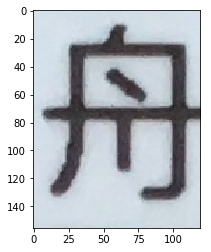

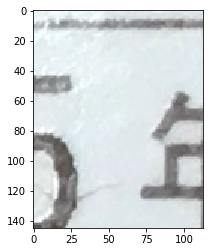

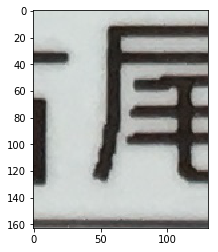

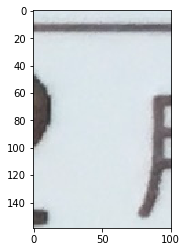

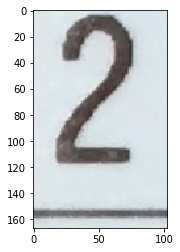

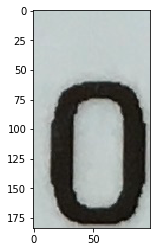

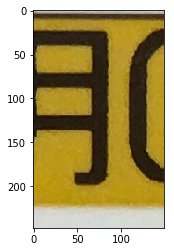

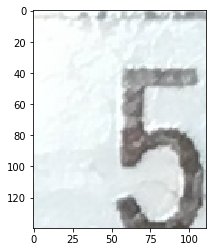

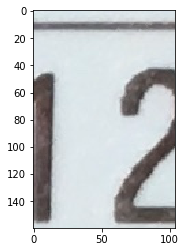

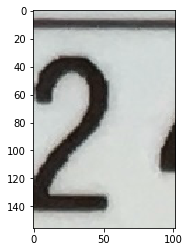

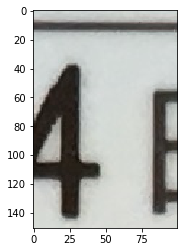

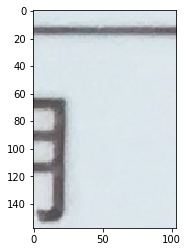

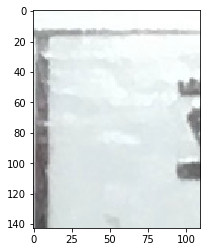

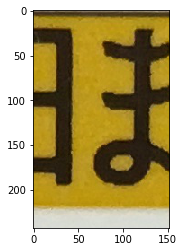

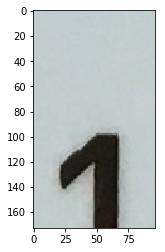

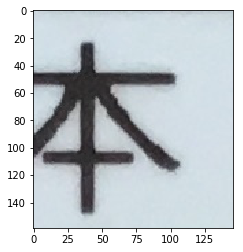

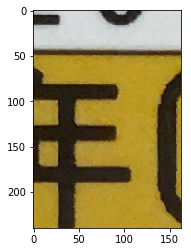

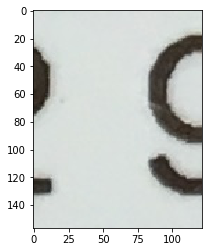

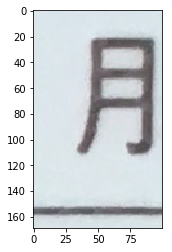

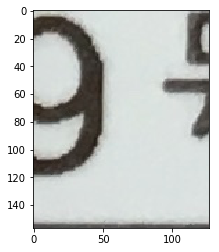

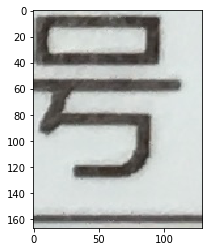

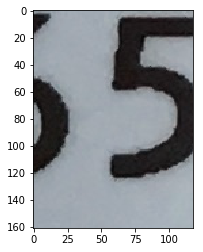

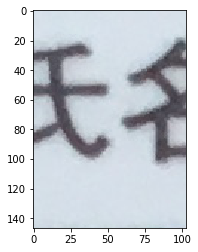

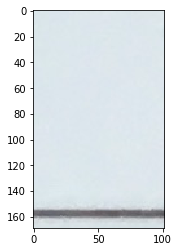

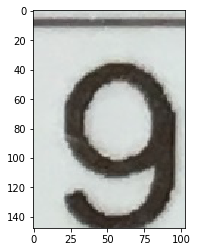

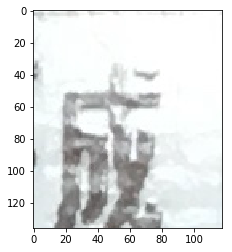

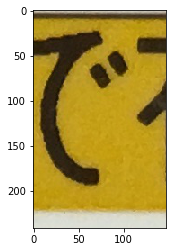

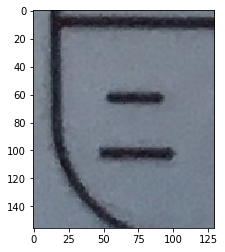

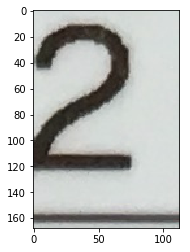

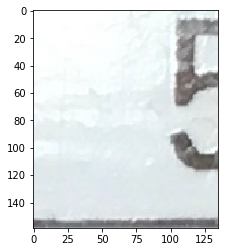

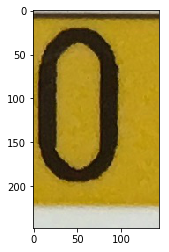

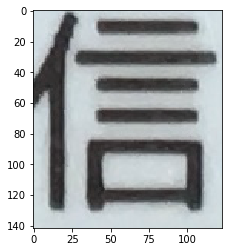

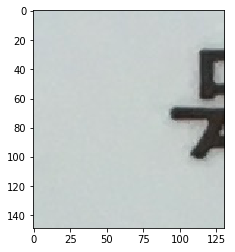

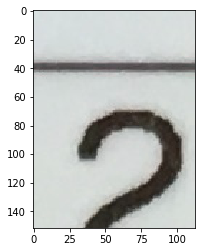

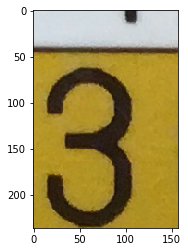

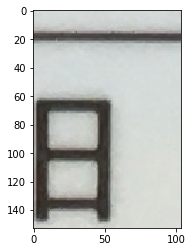

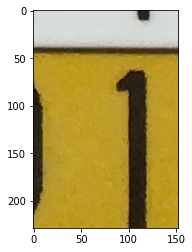

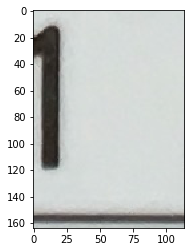

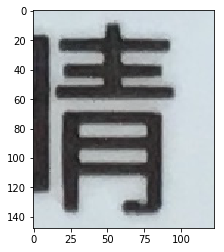

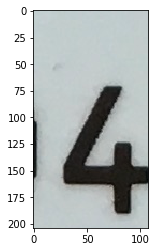

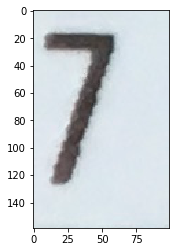

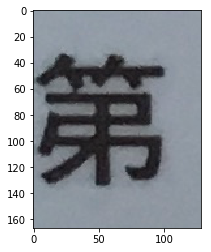

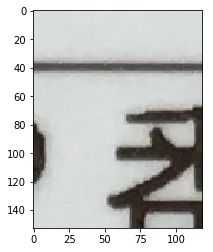

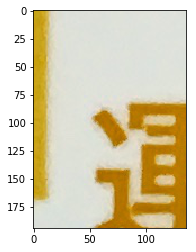

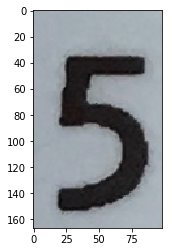

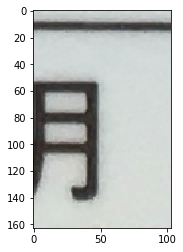

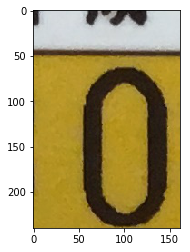

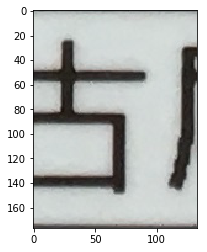

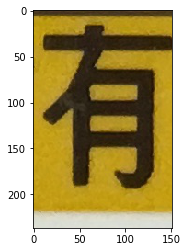

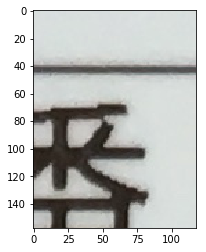

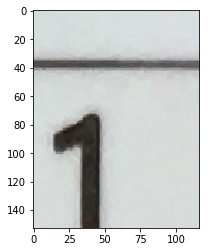

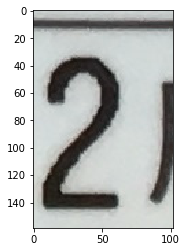

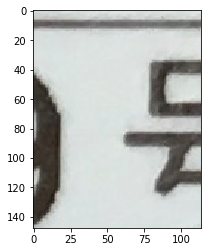

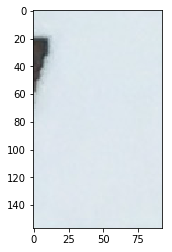

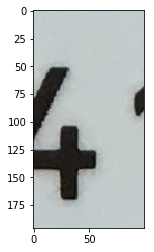

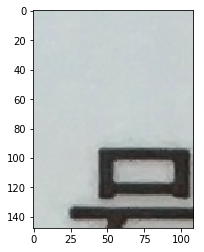

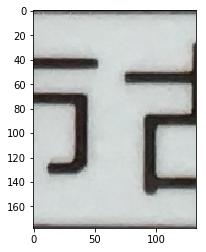

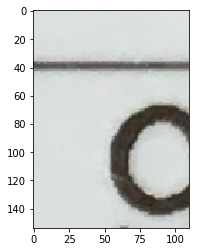

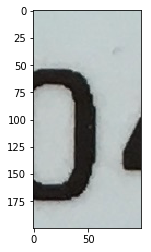

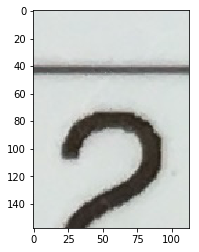

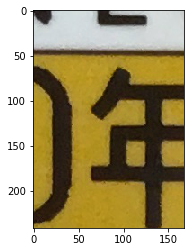

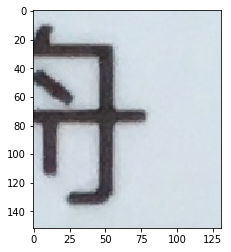

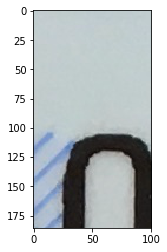

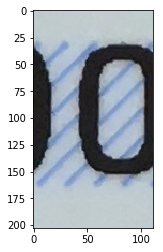

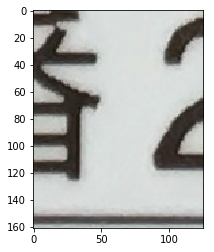

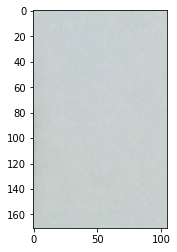

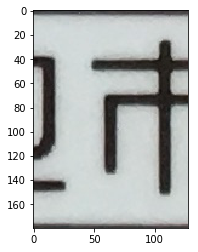

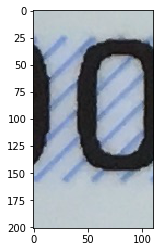

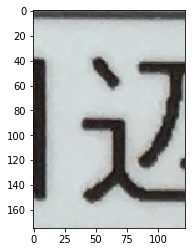

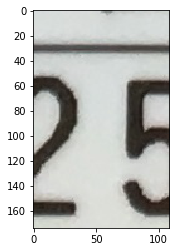

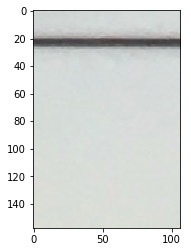

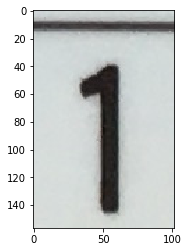

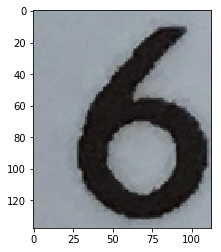

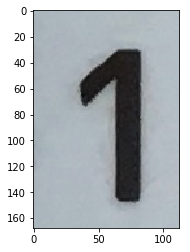

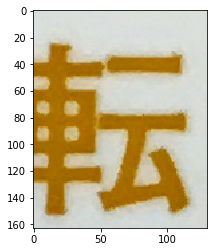

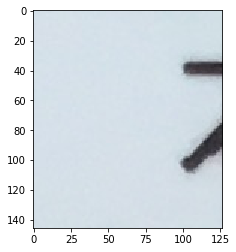

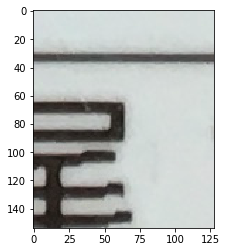

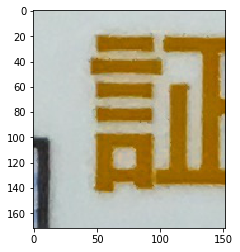

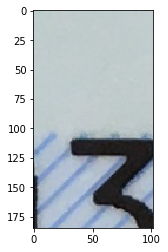

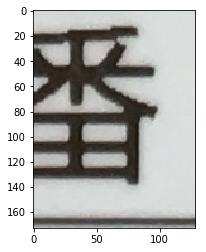

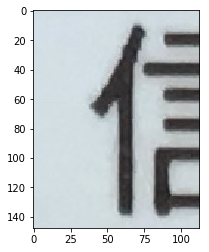

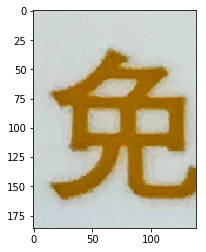

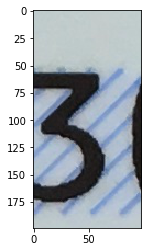

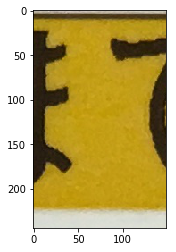

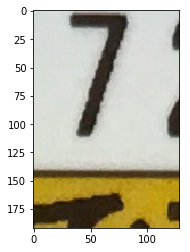

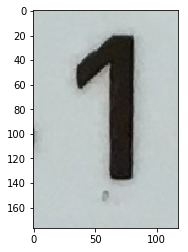

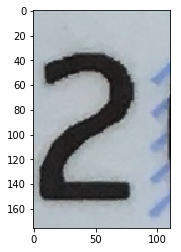

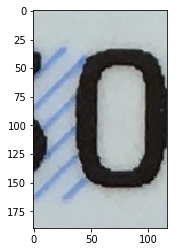

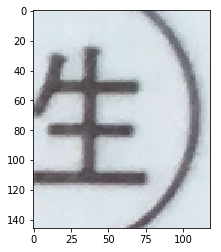

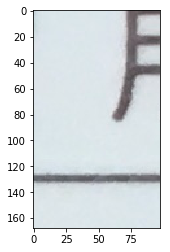

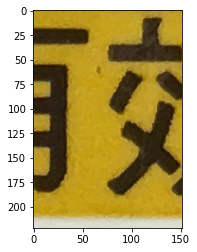

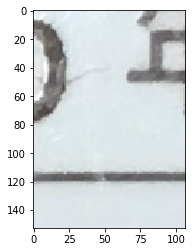

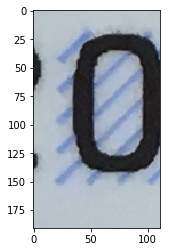

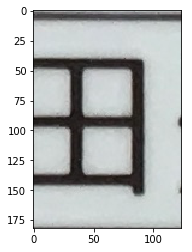

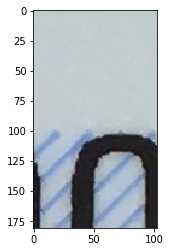

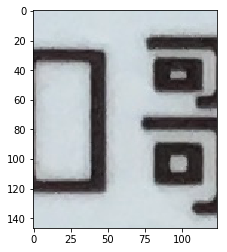

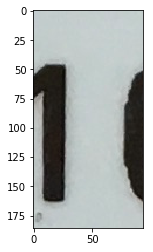

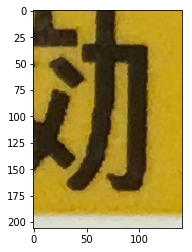

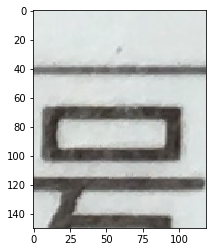

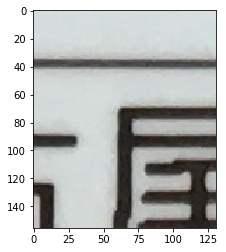

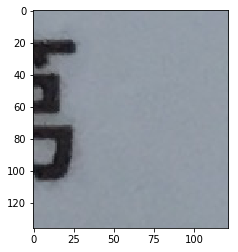

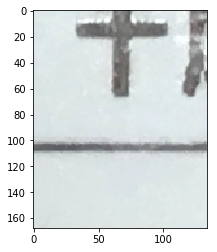

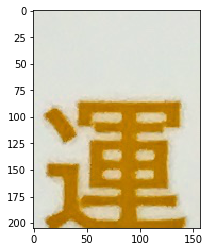

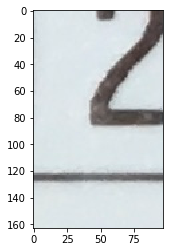

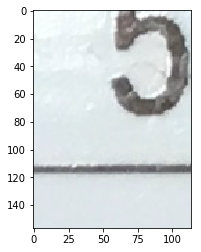

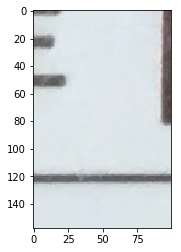

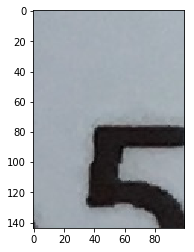

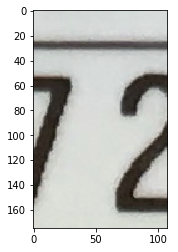

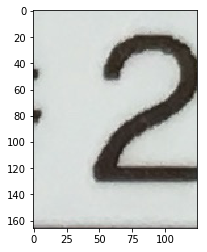

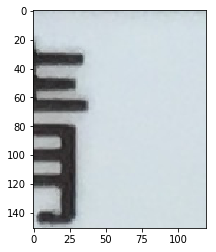

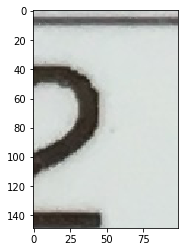

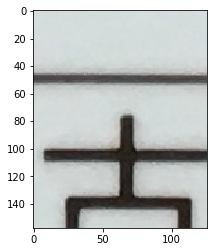

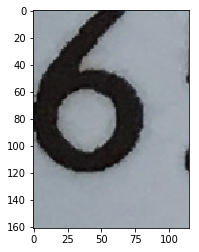

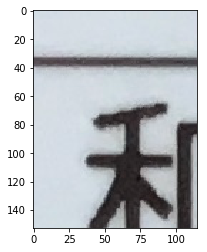

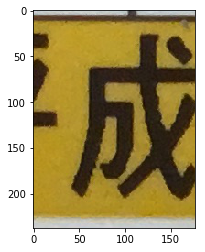

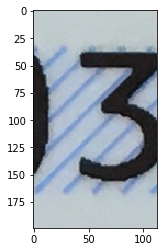

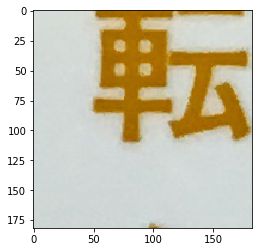

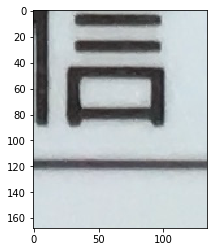

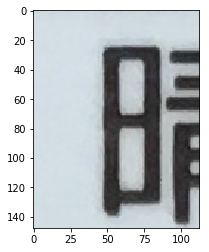

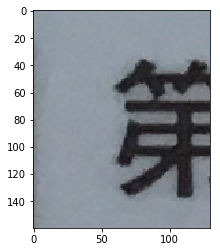

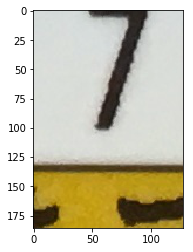

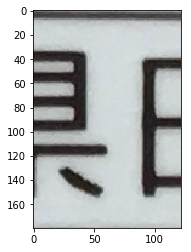

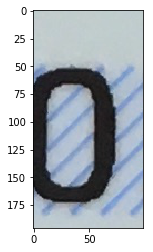

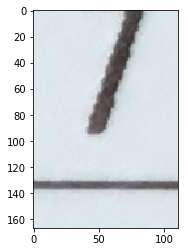

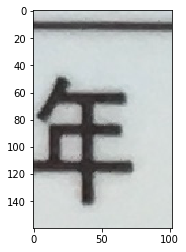

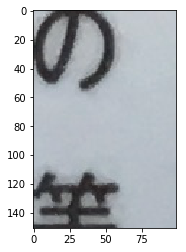

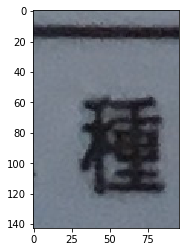

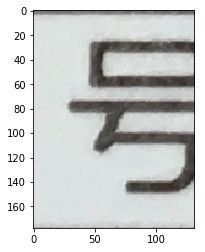

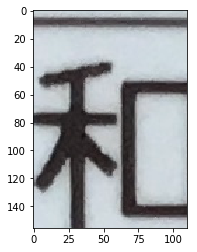

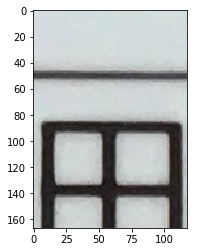

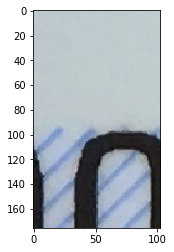

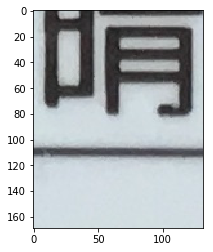

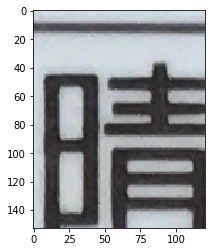

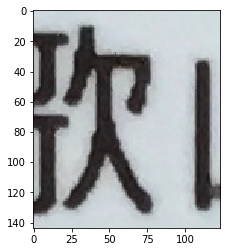

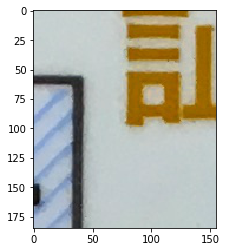

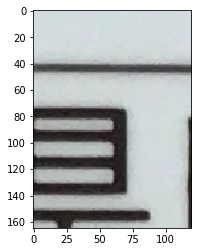

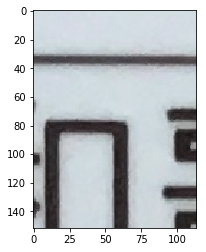

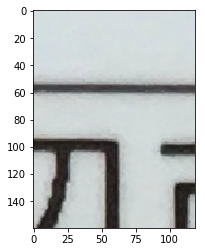

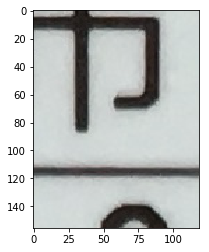

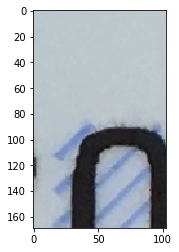

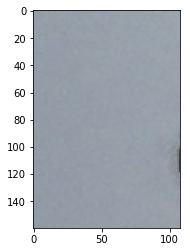

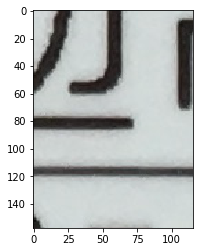

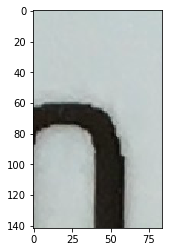

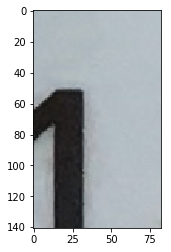

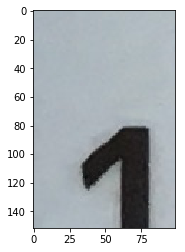

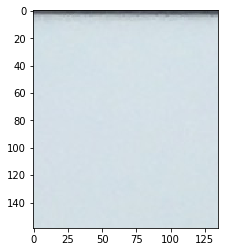

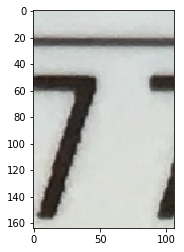

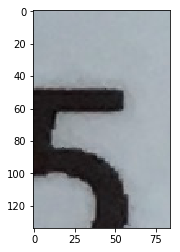

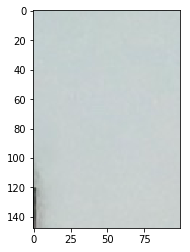

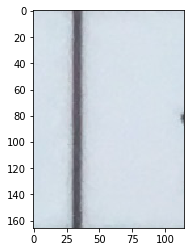

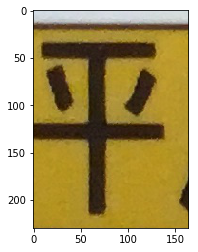

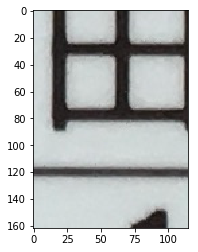

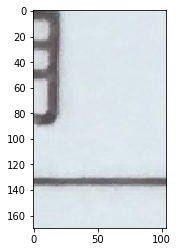

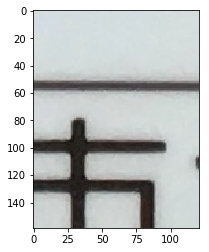

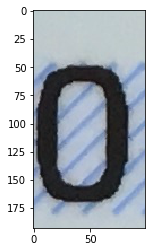

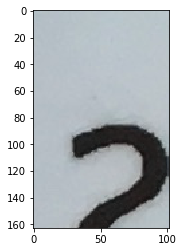

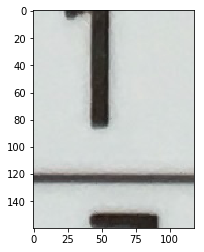

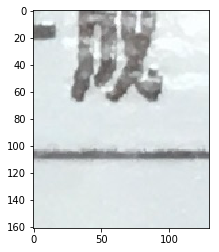

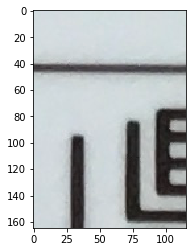

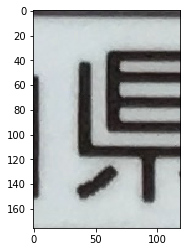

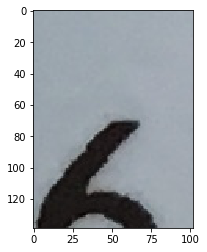

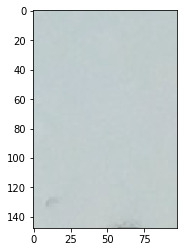

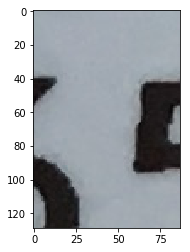

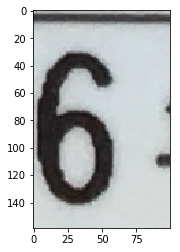

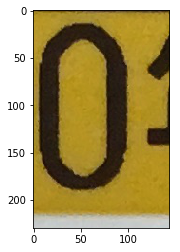

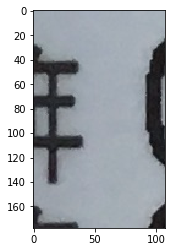

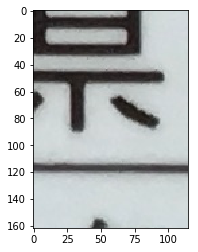

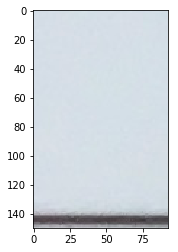

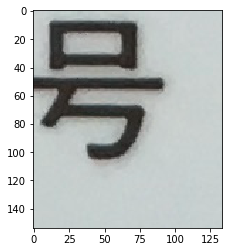

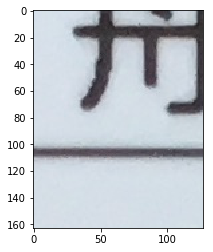

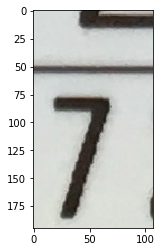

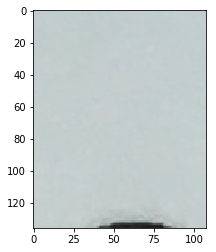

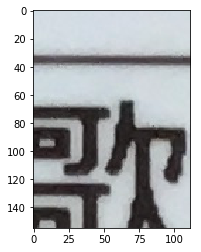

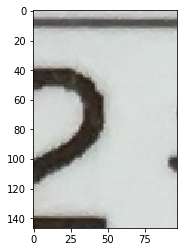

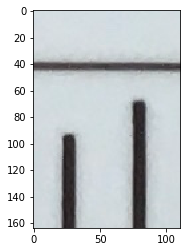

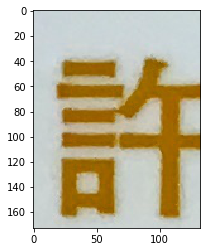

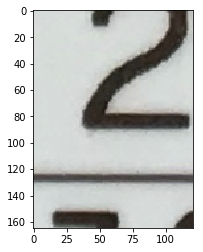

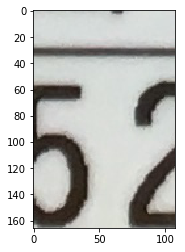

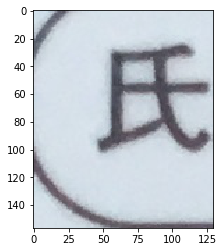

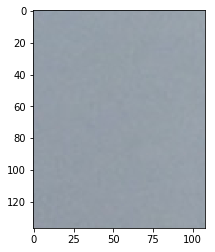

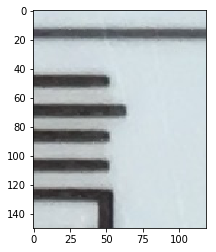

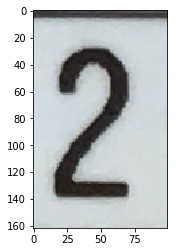

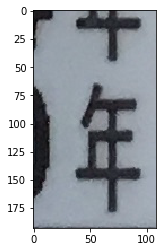

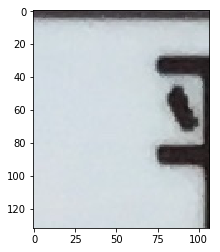

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_size = 200

#img_path = cv2.imread('predict_image/menkyosyou.jpg')
images = np.load('trim/trimming_images.npy')
image_point = np.load('trim/image_point.npy')


trimming_img = []

for img in images:
#for img in images:
    #  画像ごとにまとめた座標
    for img_point in image_point:
        # zahyou = [x1,y1,x2,y2]
        # x1,y1は左上の座標、x2,y2は右上の座標
        for zahyou in img_point:
        
            trim_img = img[zahyou[1]:zahyou[3], zahyou[0]:zahyou[2]]
            
            # なぜか切り取った後にxか
            #yの値が０ものが出てくるので、それは除外
            if trim_img.shape[0] == 0 or trim_img.shape[1] == 0:
                del trim_img
                continue
            
            #t_img = cv2.resize(trim_img,(image_size, image_size))
            
            plt.imshow(cv2.cvtColor(trim_img , cv2.COLOR_BGR2RGB))
            plt.show()  
            
            #trimming_img.append(t_img)

# SSD
１：重みをロードする
２：画像を３００×３００にリサイズする
３：１の重みを使って、２の画像のバウンディングボックスを予測する。このバウンディングボックスは３００にリサイズする前の元画像に対応する形で出力される。
４：imagesに２でリサイズする前の画像を格納してnpyで保存。image_pointには３で予測した座標を格納してnpyで保存。

# 切り取り
１：SSDの４のimagesとimage_pointをロードする。
２：images（リサイズする前の元画像）からimage_point（SSDで予測した座標）を使って画像を切り取り。
３：画像を表示

注：本来のコードでは２で元画像から切り取った後に２００×２００の画像にリサイズして保存しているが、このコードでは元画像から切り取った後にリサイズせずに画像を表示。